In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from dataset import CoralDataModule
from model import CoralSegFormer
from pathlib import Path
import random
from PIL import Image
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# UPDATE ME!
# Configure paths
user = "jrhowell"
dataset_dir = f"/home/{user}/sadow_koastore/shared/coral_seg/coral_seg/data/"
results_dir = f"/home/{user}/sadow_koastore/shared/coral_seg/coral_seg/results/"

# Configure hyperparameters
batch_size = 8 
epochs = 30
split_ratio = 0.8
num_workers = 4
samples_per_image = 100
crop_size = (512, 512)

In [3]:
# Initialize the data module
data_module = CoralDataModule(
    root_dir=dataset_dir, 
    batch_size=batch_size, 
    split_ratio=split_ratio,
    num_workers=num_workers,
    samples_per_image=samples_per_image,
    crop_size=crop_size
)

data_module.setup() 
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Scanning /home/jrhowell/sadow_koastore/shared/coral_seg/coral_seg/data/...
Found 199 valid image/mask pairs.
Training on 159 images.
Validating on 40 images.


In [4]:
# Load an example batch to determine input shape
example_batch = next(iter(train_loader))
print(example_batch)

[tensor([[[[-1.8610, -1.8610, -1.8610,  ..., -1.9124, -1.9124, -1.9124],
          [-1.8782, -1.8782, -1.8610,  ..., -1.9124, -1.9124, -1.9124],
          [-1.8610, -1.8610, -1.8610,  ..., -1.9124, -1.9124, -1.9124],
          ...,
          [-0.1657, -0.1657, -0.1314,  ..., -0.0629, -0.1143, -0.0801],
          [-0.1657, -0.1999, -0.3369,  ..., -0.1657, -0.0801, -0.0629],
          [-0.2342, -0.1657, -0.1657,  ..., -0.3027, -0.1657, -0.0972]],

         [[-1.6331, -1.6331, -1.6331,  ..., -1.7206, -1.7206, -1.7206],
          [-1.6506, -1.6506, -1.6331,  ..., -1.7206, -1.7206, -1.7206],
          [-1.6331, -1.6331, -1.6331,  ..., -1.7206, -1.7206, -1.7206],
          ...,
          [ 0.0126,  0.0126,  0.0476,  ...,  0.0826,  0.0301,  0.0651],
          [ 0.0301, -0.0049, -0.1450,  ..., -0.0224,  0.0651,  0.0826],
          [-0.0574,  0.0126,  0.0126,  ..., -0.1625, -0.0224,  0.0476]],

         [[-1.0027, -1.0027, -1.0027,  ..., -1.1073, -1.1073, -1.1073],
          [-1.0201, -1.0201, 

In [5]:
# Initialize the model
model = CoralSegFormer(learning_rate=3e-4)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath= results_dir + 'checkpoints',
    filename='coral-segformer-{epoch:02d}-{val_loss:.2f}',
    save_top_k=2,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

callbacks = [checkpoint_callback, early_stop_callback]

Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/mit-b0
Key                                           | Status     | 
----------------------------------------------+------------+-
classifier.weight                             | UNEXPECTED | 
classifier.bias                               | UNEXPECTED | 
decode_head.batch_norm.bias                   | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | MISSING    | 
decode_head.classifier.bias                   | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | MISSING    | 
decode_head.classifier.weight                 | MISSING    | 
decode_head.batch_norm.num_batches_tracked    | MISSING    | 
decode_head.batch_norm.running_mean           | MISSING    | 
decode_head.batch_norm.weight                 | MISSING    | 
decode_head.batch_norm.running_var            | MISSING    | 
decode_head.linear_fuse.weight                | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different ta

In [6]:
# Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto", # Auto-detects GPU/CPU
    devices=1,
    callbacks=callbacks,
    log_every_n_steps=10
)

# Train
print("Starting Training...")
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/home/jrhowell/.conda/envs/coral_seg_v2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Starting Training...


/home/jrhowell/.conda/envs/coral_seg_v2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Scanning /home/jrhowell/sadow_koastore/shared/coral_seg/coral_seg/data/...
Found 199 valid image/mask pairs.
Training on 159 images.
Validating on 40 images.



  | Name  | Type                             | Params | Mode | FLOPs
--------------------------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M  | eval | 0    
--------------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.862    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode
0         Total Flops
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jrhowell/.conda/envs/coral_seg_v2/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:534: Found 213 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
repo_root = Path.cwd().parent  # .../coral_seg/coral_seg
ckpts = sorted(repo_root.rglob("*.ckpt"))

print("Found", len(ckpts), "ckpt(s)")
for p in ckpts[:50]:
    print(p)

Found 4 ckpt(s)
/mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints/coral-segformer-epoch=00-val_loss=0.35.ckpt
/mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints/coral-segformer-epoch=01-val_loss=0.26.ckpt
/mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints/coral-segformer-epoch=03-val_loss=0.24.ckpt
/mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints/coral-segformer-epoch=03-val_loss=0.43.ckpt


In [8]:
repo_root = Path.cwd().parent
ckpt_path = repo_root / "results" / "checkpoints" / "coral-segformer-epoch=03-val_loss=0.24.ckpt"

print("Loading:", ckpt_path)
assert ckpt_path.exists()

model = CoralSegFormer.load_from_checkpoint(str(ckpt_path), map_location="cuda", strict=False)
model.eval().cuda()

Loading: /mnt/lustre/koa/koastore/sadow_group/shared/coral_seg/coral_seg/results/checkpoints/coral-segformer-epoch=03-val_loss=0.24.ckpt


Loading weights:   0%|          | 0/192 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/mit-b0
Key                                           | Status     | 
----------------------------------------------+------------+-
classifier.weight                             | UNEXPECTED | 
classifier.bias                               | UNEXPECTED | 
decode_head.batch_norm.bias                   | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.bias   | MISSING    | 
decode_head.classifier.bias                   | MISSING    | 
decode_head.linear_c.{0, 1, 2, 3}.proj.weight | MISSING    | 
decode_head.classifier.weight                 | MISSING    | 
decode_head.batch_norm.num_batches_tracked    | MISSING    | 
decode_head.batch_norm.running_mean           | MISSING    | 
decode_head.batch_norm.weight                 | MISSING    | 
decode_head.batch_norm.running_var            | MISSING    | 
decode_head.linear_fuse.weight                | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different ta

CoralSegFormer(
  (model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_

In [10]:
# root directory containing many subfolders
root_dir = Path( f"/home/{user}/sadow_koastore/shared/coral_seg/coral_seg/data/")

# find all image.png files recursively
image_paths = list(root_dir.rglob("image.png"))

assert len(image_paths) > 0, "No image.png files found!"

# randomly select one
img_path = random.choice(image_paths)
print(f"Using image: {img_path}")

# IMPORTANT: match training transforms
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    # Uncomment if used during training
    # T.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]),
])

img = Image.open(img_path).convert("RGB")

x = transform(img).unsqueeze(0)
x = x.cuda() if torch.cuda.is_available() else x

Using image: /home/jrhowell/sadow_koastore/shared/coral_seg/coral_seg/data/MC294_D1_OIII/image.png


In [12]:
with torch.no_grad():
    outputs = model(x)          # SemanticSegmenterOutput
    logits = outputs.logits     # Tensor [1, C, H, W]
    pred = logits.argmax(dim=1)

pred_mask = pred.squeeze(0).cpu().numpy()

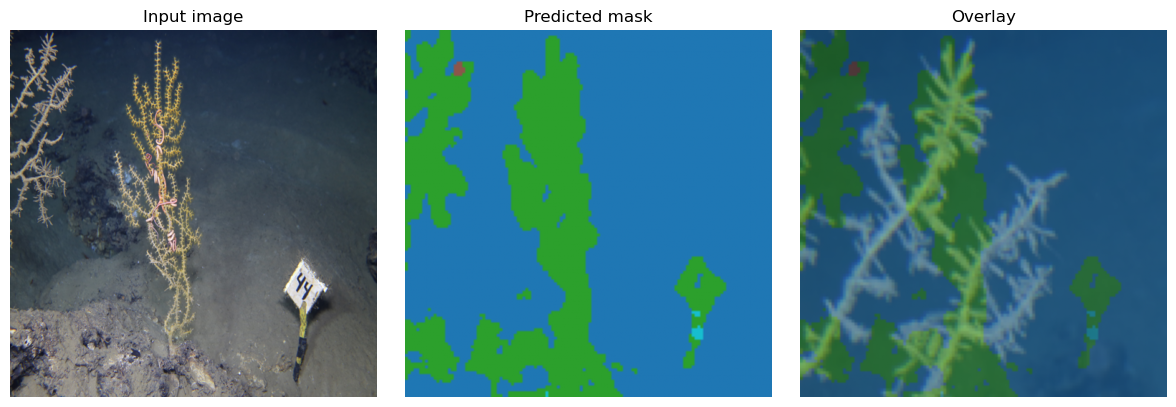

In [13]:
img_np = np.array(img.resize((512, 512)))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Input image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(pred_mask, cmap="tab10", vmin=0, vmax=4)
plt.title("Predicted mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_np)
plt.imshow(pred_mask, cmap="tab10", alpha=0.5, vmin=0, vmax=4)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()